# Sentiment Analysis
In this notebook we are going to use 3 techniques:


1.   Vader
2.   Roberta Pretrained Model from Huggingface
3.Huggingface Pipeline



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
# !pip install nltk

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashmori09","key":"1c8b827a9c0e190cf5b0d011eb774e87"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir amazon_review

In [ ]:
%cd amazon_review

/content/amazon_review


In [ ]:
!kaggle datasets list -s Amazon-Fine-Food-Reviews


ref                                     title                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------  --------------------------  -----  -------------------  -------------  ---------  ---------------  
snap/amazon-fine-food-reviews           Amazon Fine Food Reviews    242MB  2017-05-01 18:51:31         143967       1995  0.7941176        
ajaysh/amazon-fine-food-reviews         Amazon Fine Food Reviews    128MB  2018-05-15 10:01:32            340          9  0.4117647        
jitensharma597/text-summarize-data      Text_summarize_data         977MB  2022-11-22 17:05:11              6          0  0.29411766       
wolfram77/graphs-online-reviews         Online reviews Graphs         3GB  2021-11-12 07:43:43             17          2  0.875            
apoorvaduraisamy/mydataset              mydataset                    14KB  2021-02-05 14:48:11              5          1  0.125            
satyabrat35/amazon-f

In [ ]:
!kaggle datasets download snap/amazon-fine-food-reviews


100% 241M/242M [00:01<00:00, 230MB/s]
100% 242M/242M [00:01<00:00, 215MB/s]


In [ ]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [ ]:
df=pd.read_csv('/content/amazon_review/Reviews.csv')
df=df.head(500)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
df.shape

(500, 10)

# EDA

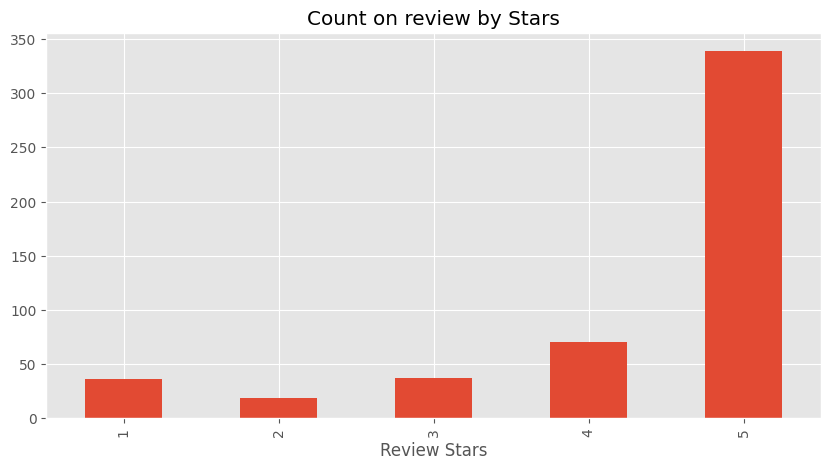

In [ ]:
ax=df['Score'].value_counts().sort_index() \
  .plot(kind='bar',
        title='Count on review by Stars',
        figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()  

# Basic NLTK

In [ ]:
example= df['Text'].values[50]
example

"This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go."

In [ ]:
nltk.download('punkt')
tokens=nltk.word_tokenize(example)
tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [ ]:
nltk.download('averaged_perceptron_tagger')
tagge=nltk.pos_tag(tokens)
tagge[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities=nltk.chunk.ne_chunk(tagge)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1: VADER Sentiment Scoring

In [ ]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sia.polarity_scores('I am so Happy!!')

{'neg': 0.0, 'neu': 0.304, 'pos': 0.696, 'compound': 0.6785}

In [ ]:
sia.polarity_scores('This is the Worst thing ever!!')

{'neg': 0.484, 'neu': 0.516, 'pos': 0.0, 'compound': -0.6892}

In [ ]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
#Run the polarity score on the entire dataset
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
  text= row['Text']
  myid=row['Id']
  res[myid]=sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
vaders=pd.DataFrame(res).T
vaders=vaders.reset_index().rename(columns={'index':'Id'})
vaders= vaders.merge(df,how='left')

In [ ]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Plot Vaders Results

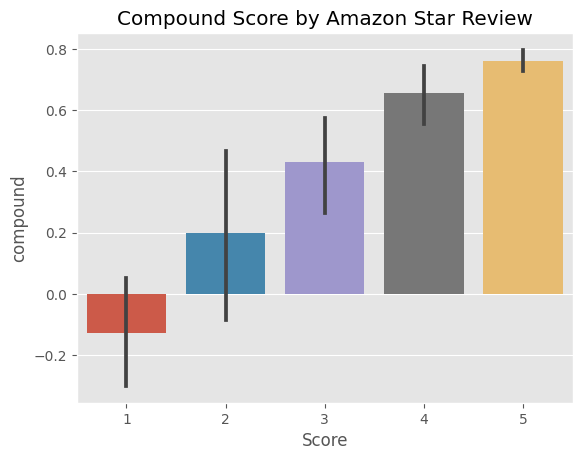

In [ ]:
ax=sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

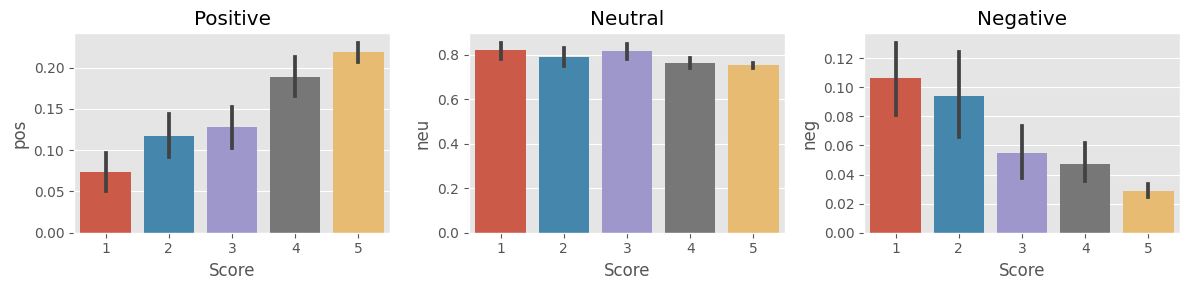

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders,x='Score',y='pos',ax=axs[0])
sns.barplot(data=vaders,x='Score',y='neu',ax=axs[1])
sns.barplot(data=vaders,x='Score',y='neg',ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step-3 Roberta Pretrained Model

In [ ]:
!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.8 MB/s eta 0:00:00


In [ ]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer= AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# Vader Results on Example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [ ]:
# Run for Roberto Model
def polarity_scores_roberta(example):
  encoded_text=tokenizer(example,return_tensors='pt')
  output=model(**encoded_text)
  scores=output[0][0].detach().numpy()
  scores=softmax(scores)
  scores_dict={
      'roberta_neg':scores[0],
      'roberta_neu':scores[1],
      'roberta_pos':scores[2]

  }
  return scores_dict

In [ ]:
res={}
for i,row in tqdm(df.iterrows(),total=len(df)):
    try: 
        text= row['Text']
        myid=row['Id']
        vader_result=sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        roberta_result=polarity_scores_roberta(text)
        both={**vader_result,**roberta_result}
        res[myid] = both
    except RuntimeError:
         print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
both

{'neg': 0.22,
 'neu': 0.78,
 'pos': 0.0,
 'compound': -0.5448,
 'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687476,
 'roberta_pos': 0.002957372}

In [ ]:
result_df=pd.DataFrame(res).T
result_df=result_df.reset_index().rename(columns={'index':'Id'})
result_df= result_df.merge(df,how='left')
result_df

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,0.029,0.809,0.163,0.8830,0.006130,0.021796,0.972075,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,0.034,0.693,0.273,0.9346,0.001305,0.007774,0.990921,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,0.000,0.520,0.480,0.9487,0.002029,0.005685,0.992285,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,0.000,0.851,0.149,0.6369,0.003874,0.094156,0.901970,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,0.000,0.705,0.295,0.8313,0.003103,0.055912,0.940984,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


# Compare Scores Between Models

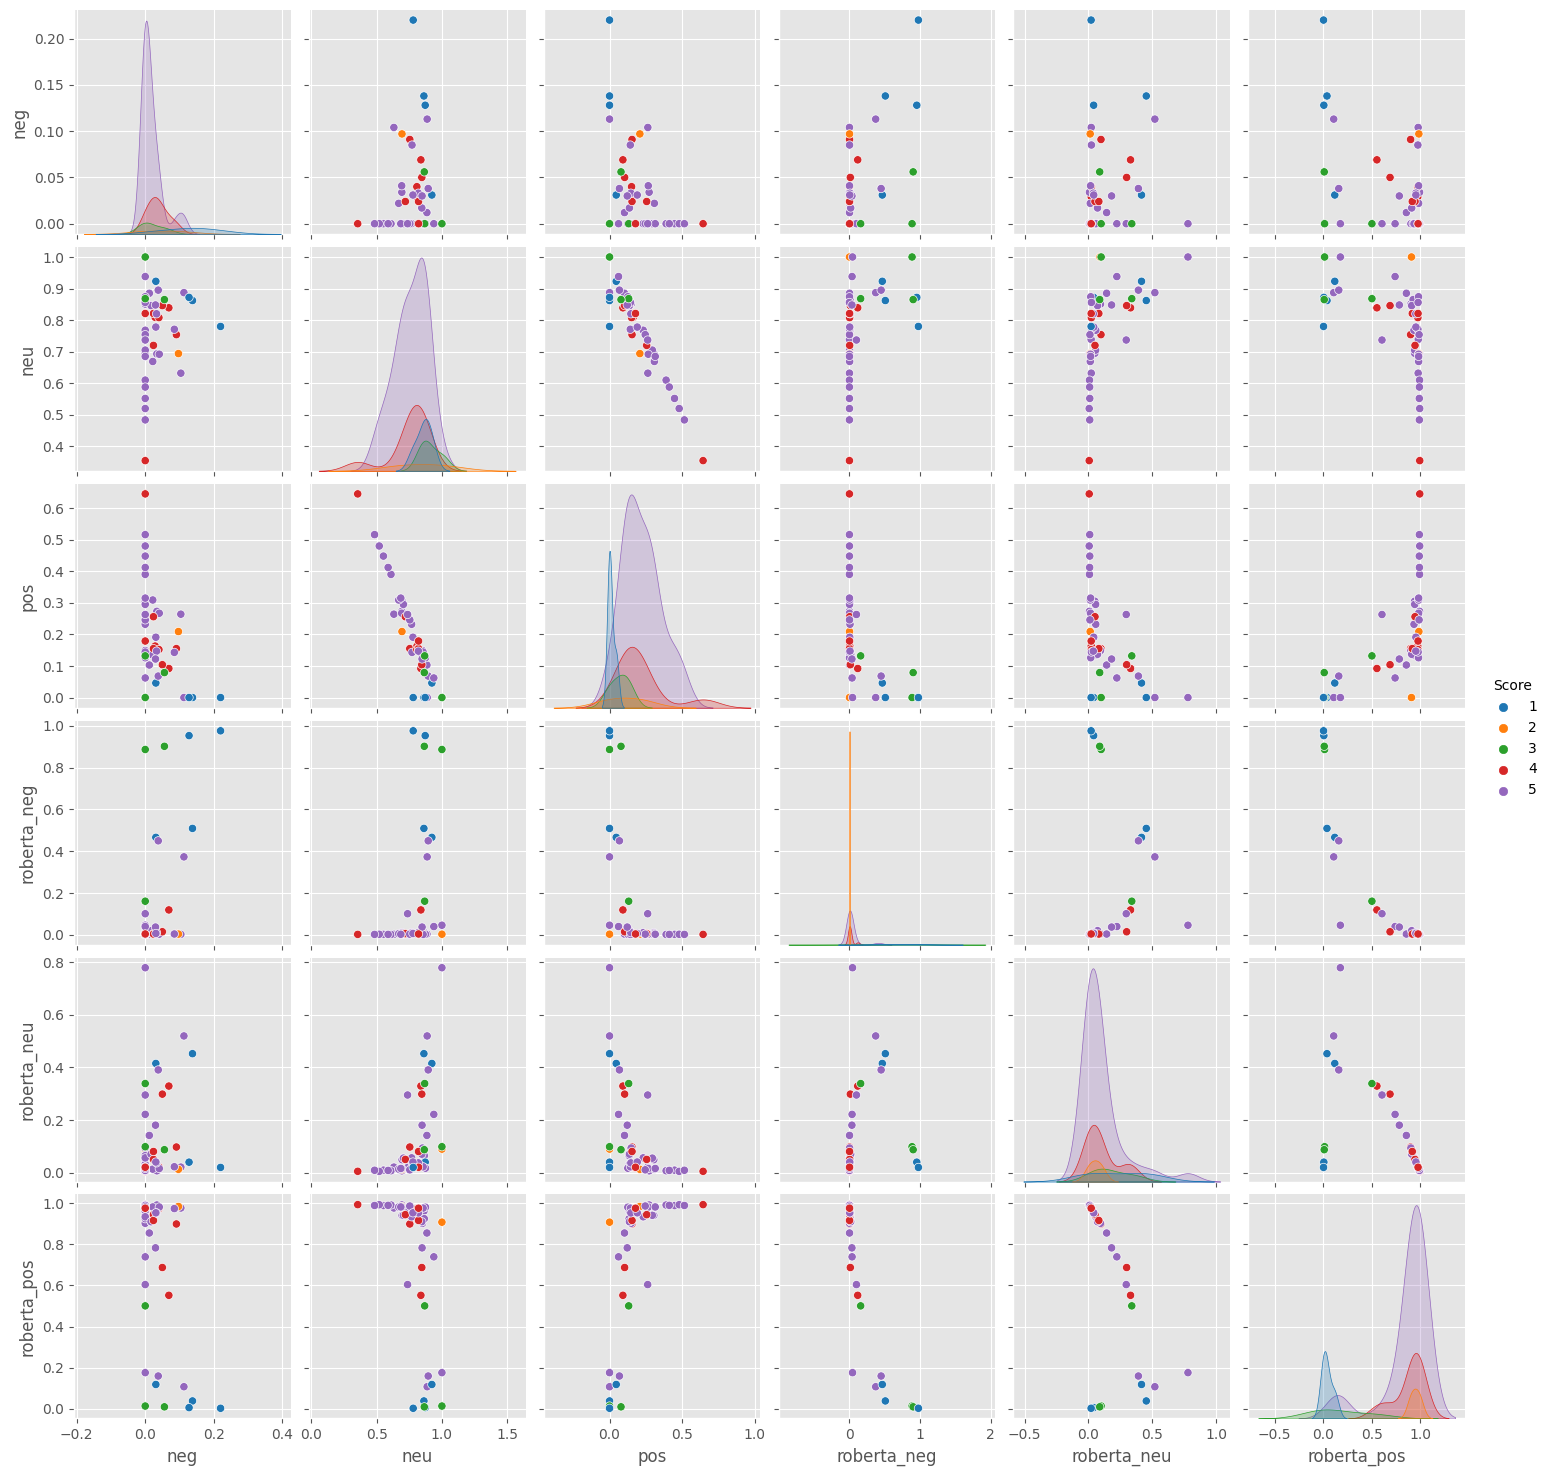

In [ ]:
sns.pairplot(data=result_df,vars=['neg', 'neu', 'pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10'
             )
plt.show()

# Step 4: Review Examples:

In [ ]:
# postive sentiment with 1 star view
result_df.query('Score==1').sort_values('roberta_pos',ascending=False)['Text'].values[0] 

"My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat."

In [ ]:
result_df.query('Score==1').sort_values('pos',ascending=False)['Text'].values[0] 

"My cats have been happily eating Felidae Platinum for more than two years. I just got a new bag and the shape of the food is different. They tried the new food when I first put it in their bowls and now the bowls sit full and the kitties will not touch the food. I've noticed similar reviews related to formula changes in the past. Unfortunately, I now need to find a new food that my cats will eat."

In [ ]:
# negative sentiment with 5 star view
result_df.query('Score==5').sort_values('roberta_neg',ascending=False)['Text'].values[0] 

"I have lived out of the US for over 7 yrs now, and I so miss my Twizzlers!!  When I go back to visit or someone visits me, I always stock up.  All I can say is YUM!<br />Sell these in Mexico and you will have a faithful buyer, more often than I'm able to buy them right now."

In [ ]:
result_df.query('Score==5').sort_values('neg',ascending=False)['Text'].values[0] 

"One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week."

# The Transformers Pipeline

In [ ]:
from transformers import pipeline
sent_pipeline=pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
sent_pipeline("BIRD IS SITTING THERE ")

[{'label': 'POSITIVE', 'score': 0.9547962546348572}]